<a href="https://www.kaggle.com/code/merveintepe/ann-fish-dataset?scriptVersionId=203196753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

In [87]:
#Kütüphaneler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings("ignore")

# #Explore Data

In [88]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
print(classes)
print(len(classes))

['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']
9


In [89]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

# #Data Analys

In [90]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [91]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


(9000, 2)

In [92]:
print(data.describe())
print(data.dtypes)

                                                     path            label
count                                                9000             9000
unique                                               9000                9
top     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
freq                                                    1             1000
path     object
label    object
dtype: object


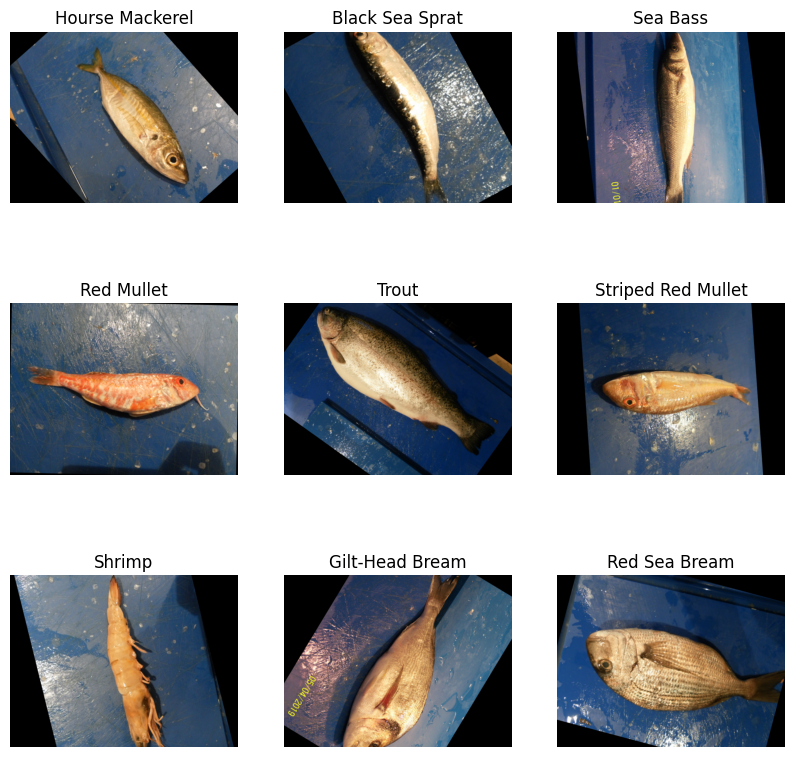

In [93]:
cn = 0
plt.figure(figsize=(10,10))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    cn+=1

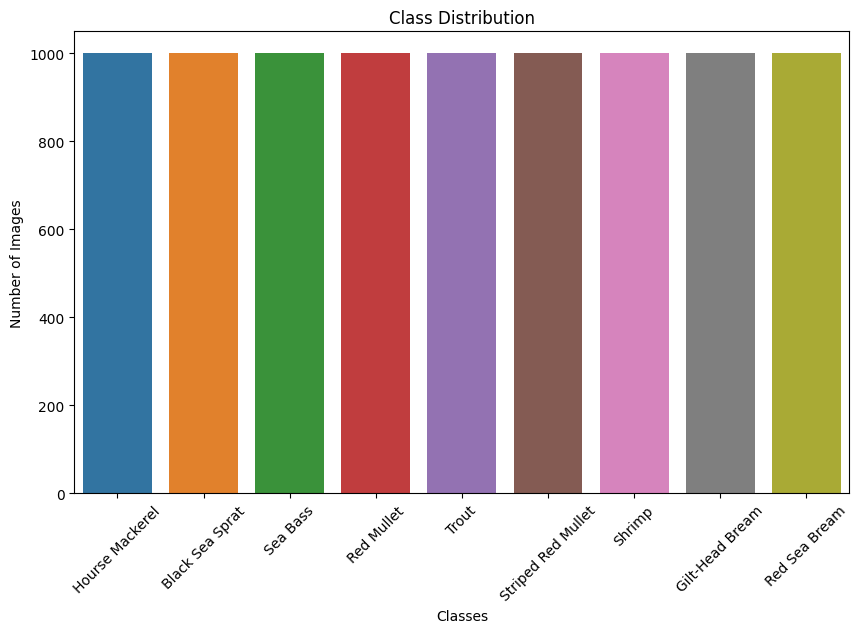

In [94]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  
plt.show()

In [95]:
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

In [96]:
# Check for missing values
missing_images = data.isnull().sum()
print(missing_images)

path     0
label    0
dtype: int64


In [97]:
from PIL import Image
img = Image.open(path[0])
width, height = img.size
total_pixels = width * height

print(f"Genişlik: {width} piksel")
print(f"Yükseklik: {height} piksel")
print(f"Toplam piksel sayısı: {total_pixels}") 

Genişlik: 590 piksel
Yükseklik: 445 piksel
Toplam piksel sayısı: 262550


# #Splitting The Data Train-Validation-Test

In [98]:
# train test 
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=1)

In [99]:
print(train_data.shape)
print(test_data.shape)

(7200, 2)
(1800, 2)


In [100]:
print(train_data.dtypes)
print(train_data)

path     object
label    object
dtype: object
                                                   path               label
7289  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Gilt-Head Bream
8192  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream
6247  /kaggle/input/a-large-scale-fish-dataset/Fish_...              Shrimp
8073  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Sea Bream
7804  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Gilt-Head Bream
...                                                 ...                 ...
2895  /kaggle/input/a-large-scale-fish-dataset/Fish_...            Sea Bass
7813  /kaggle/input/a-large-scale-fish-dataset/Fish_...     Gilt-Head Bream
905   /kaggle/input/a-large-scale-fish-dataset/Fish_...     Hourse Mackerel
5192  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet
235   /kaggle/input/a-large-scale-fish-dataset/Fish_...     Hourse Mackerel

[7200 rows x 2 columns]


In [101]:
import numpy as np

print("{} unique labels.".format(np.unique(train_data["label"])))

['Black Sea Sprat' 'Gilt-Head Bream' 'Hourse Mackerel' 'Red Mullet'
 'Red Sea Bream' 'Sea Bass' 'Shrimp' 'Striped Red Mullet' 'Trout'] unique labels.


# Data Generation 
resim işlemesi için uygun hale getirip, etiketlerini encode ediyoruz

In [102]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)

datagen_test=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_image = datagen.flow_from_dataframe(dataframe = train_data, directory=None, x_col='path', y_col='label', target_size=(224,224), color_mode='rgb',class_mode='categorical', subset='training',batch_size=32,seed=42,shuffle=True)
validation_image = datagen.flow_from_dataframe(dataframe = train_data, directory=None, x_col='path', y_col='label', target_size=(224,224),color_mode='rgb',class_mode='categorical',subset='validation',batch_size=32,seed=42,shuffle=False)
test_image = datagen_test.flow_from_dataframe(dataframe = test_data,directory=None, x_col='path', y_col='label', target_size=(224,224), color_mode='rgb',class_mode='categorical',batch_size=32,seed=42,shuffle=False)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [103]:
display(train_image.class_indices)
display(validation_image.class_indices)
display(test_image.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [104]:
# Bir batch veriyi alalım
images, labels = next(train_image)

print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

# birkaç görüntü ve etiket
print("First batch of images:", images[:2])
print("First batch of labels:", labels[:2])

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)
First batch of images: [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0

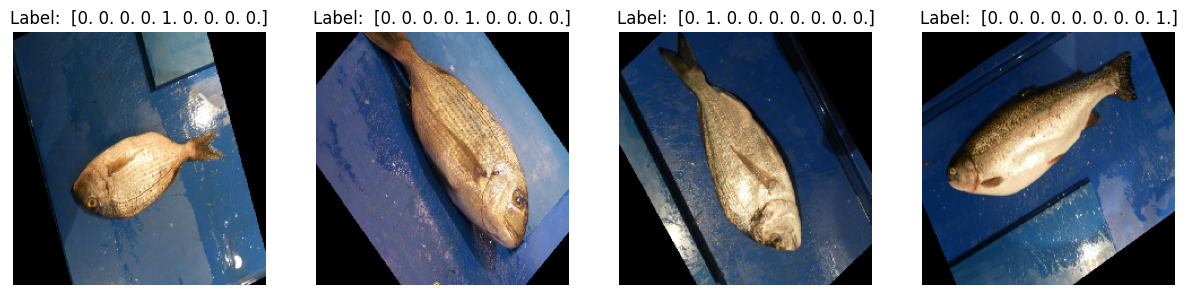

In [105]:
num_images = min(4, len(images))

plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i]) 
    plt.title(f"Label:  {(labels[i])}")  #{int(labels[i])}
    plt.axis('off') 
plt.show()

In [106]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,Rescaling

model=Sequential()

# Input katmanı
model.add(Flatten(input_shape=(224,224,3)))

# Gizli katmanlar
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu')) 
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.2))

# Output layer. Multi-class sınıflandırma için softmax kullanıyoruz.
model.add(Dense(9, activation='softmax'))

In [107]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [108]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,236,233 (294.63 MB)

 Trainable params: 77,236,233 (294.63 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
#modeli eğitme
results = model.fit(train_image,batch_size=128, epochs=10,validation_data=validation_image,callbacks=Callback)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 383ms/step - accuracy: 0.9250 - loss: 0.2297 - val_accuracy: 0.8194 - val_loss: 0.5487
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 379ms/step - accuracy: 0.9042 - loss: 0.2982 - val_accuracy: 0.9132 - val_loss: 0.2638
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 378ms/step - accuracy: 0.9335 - loss: 0.2028 - val_accuracy: 0.8931 - val_loss: 0.3779
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 377ms/step - accuracy: 0.9037 - loss: 0.2779 - val_accuracy: 0.9132 - val_loss: 0.2783
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 381ms/step - accuracy: 0.9506 - loss: 0.1513 - val_accuracy: 0.9132 - val_loss: 0.2757
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 378ms/step - accuracy: 0.9413 - loss: 0.1891 - val_accuracy: 0.8938 - val_loss: 0.3308
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 379ms/step - accuracy: 0.9470 - loss: 0.1557 - val_accuracy: 0.7549 - val_loss: 1.1645
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 381ms/step - accuracy: 0.8770 - loss: 0

# History Model

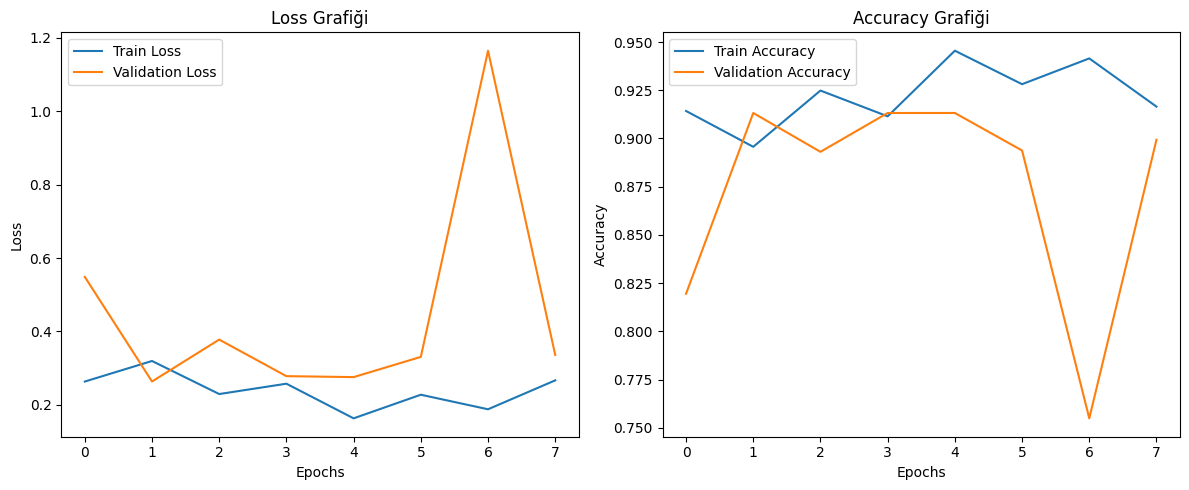

In [112]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# #Predict 

In [113]:
# Make predictions on the test data
y_pred = model.predict(test_image)
y_pred_classes = np.argmax(y_pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 312ms/step


# #Classification Report, Confusion Matrix

Accuracy: 0.9
                    0           1           2           3           4  \
precision    0.958824    0.892683    0.953757    0.968750    0.984772   
recall       0.867021    0.910448    0.808824    0.953846    0.928230   
f1-score     0.910615    0.901478    0.875332    0.961240    0.955665   
support    188.000000  201.000000  204.000000  195.000000  209.000000   

                    5           6           7           8  accuracy  \
precision    0.689189    0.994413    0.928177    0.864734       0.9   
recall       0.985507    0.890000    0.840000    0.913265       0.9   
f1-score     0.811133    0.939314    0.881890    0.888337       0.9   
support    207.000000  200.000000  200.000000  196.000000       0.9   

             macro avg  weighted avg  
precision     0.915033      0.914248  
recall        0.899682      0.900000  
f1-score      0.902778      0.902442  
support    1800.000000   1800.000000  
Confusion Matrix (test): 
 [[163   1   1   0   0  19   0   0   4]
 [ 

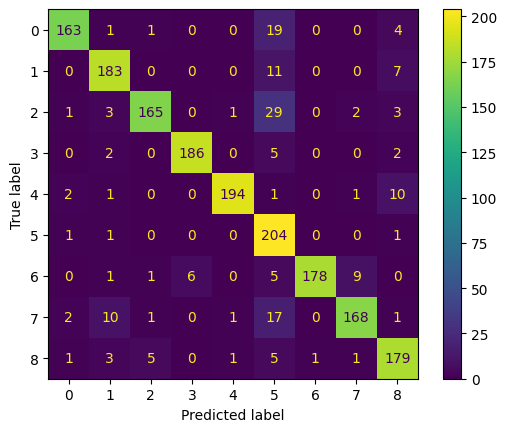

In [114]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the accuracy of the model
accuracy = accuracy_score(test_image.labels, y_pred_classes)
print('Accuracy:', accuracy)

report = pd.DataFrame(classification_report(test_image.labels, y_pred_classes, output_dict=True))
print(report)


# Create a confusion matrix
print(f"Confusion Matrix (test): \n {confusion_matrix(test_image.labels, y_pred_classes)}\n")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_image.labels, y_pred_classes))
disp.plot()

In [116]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Encode the true labels (test_images.labels) and the predicted labels (y_pred_classes)
encoder = LabelEncoder()
test_labels = encoder.fit_transform(test_image.labels)  # Transform test set labels
prediction_labels = encoder.fit_transform(y_pred_classes)  # Transform predicted labels

# Generate the classification report
print(classification_report(test_labels, prediction_labels))
accuracy = accuracy_score(test_labels, prediction_labels)
print("Test Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       188
           1       0.89      0.91      0.90       201
           2       0.95      0.81      0.88       204
           3       0.97      0.95      0.96       195
           4       0.98      0.93      0.96       209
           5       0.69      0.99      0.81       207
           6       0.99      0.89      0.94       200
           7       0.93      0.84      0.88       200
           8       0.86      0.91      0.89       196

    accuracy                           0.90      1800
   macro avg       0.92      0.90      0.90      1800
weighted avg       0.91      0.90      0.90      1800

Test Accuracy: 0.9


# *****Predict İmage*****

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted class for the image is: Red Mullet


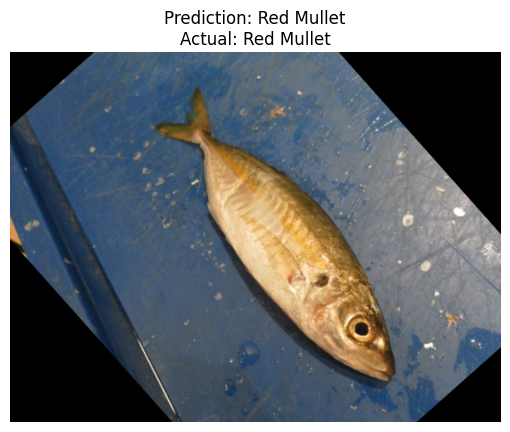

In [119]:
def predict_image(image_path):
    
 try:
    img = Image.open(image_path)

    # Preprocess the image (resize and normalize)
    img = img.resize((224, 224)) # Adjust size if necessary
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    predictions = model.predict(img_array)

    # Get the predicted class (assuming it's a single-label classification)
    predicted_class = np.argmax(predictions)

    # Replace with your class names
    class_names = ['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream'] # Example class names

    predicted_class_name = class_names[predicted_class]
    return predicted_class_name

 except FileNotFoundError:
    return "Image file not found."
 except Exception as e:
    return f"An error occurred: {e}"

# Example usage
image_path = '/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Red Mullet/00045.png' 
prediction = predict_image(image_path)
print(f"The predicted class for the image is: {prediction}")

#write actual index 
class_names=['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream'] 
true_class_index=3

# Display the image with prediction and actual class
plt.imshow(img) 
plt.title(f'Prediction: {prediction}\nActual: {class_names[true_class_index]}')
plt.axis('off') 
plt.show() 